# Gaussian Process Regression

In this notebook, we implement Gaussian Process regression described in chapter 6 of the book PRML. 

In short, Gaussian Process regression is essentially a Bayesian regression method, with the prior for the function to be estimated being Gaussian Process.

In [1]:
import numpy as np
from scipy.linalg import eigh
from scipy.optimize import minimize
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
np.random.seed(42)

# 1 Setting 

* Let $N \in \mathbb{N}$ be the number of data points. 
* Let $d \in \mathbb{N}$ be the dimension of input data.
* Denote input data by $x_0, x_1, \dots , x_{N-1} \in \mathbb{R}^d$, and output (label) data by $t_0, t_1, \dots, t_{N-1} \in \mathbb{R}$. Also, let $t := (t_0, \dots, t_{N-1})^T \in \mathbb{R}^N$.

# 2 Theory 

## 2.1 Gaussian Processes

In the Gaussian process regression, we use Gaussian processes as a prior for the function to be estimated. 
In this section, we take a look at properties of Gaussian processes themselves.


### 2.1.1 Definition

A gaussian process is defined as a random variable over real-valued functions defined on a set $X$ (which will be taken to be $\mathbb{R}^d$ in this notebook), with the property that, 
there exist $\mu : X \rightarrow \mathbb{R}$ and $k: X \times X \rightarrow \mathbb{R}$ such that, 
for an arbitrary $N \in \mathbb{N}$ and arbitrary $x_0, x_1, \dots, x_{N-1} \in X$, 
the value of the function $y : X \rightarrow \mathbb{R}$ 
generated from the Gaussian process on the points $x_0, x_1, \dots, x_{N-1} \in X$ has the joint probability density 
$$
\begin{align}
    p\left(y(x_0), y(x_1), \dots, y(x_{N-1}) \middle| \mu,k \right) 
    = \mathcal{N}\left((y(x_0), y(x_1), \dots, y(x_{N-1}) )^T \middle| M, K \right), 
\end{align}
$$
where
$$
\begin{align}
    \mathcal{N} &: \mbox{ probability density of Gaussian distribution} \\
    M &:= \left(\mu(x_0), \mu(x_1), \dots, \mu(x_{N-1}) \right)^T \ \ \in \mathbb{R}^N \\
    K &:= \left( K_{i,j} \right)_{i,j = 0, \dots, N-1}, \ \ K_{i,j} = k(x_i, x_j), 
    \mbox{ with $K$ being positive definite}
\end{align}
$$

We call the function $k$ a kernel function. 

Note : The definition given above is by no means mathematically rigorous, but practically sufficient, because we only care about finite input data points, i.e., finite $N$.


### 2.1.2 Mean and Variance

From the definition above, if follows that

$$
\begin{align}
    & \mathbb{E}[y(x_n)] = M_n \\
    & \mathbb{E}\left[\left(y(x_n)-M_n \right) \left( y(x_m) - M_m\right) \right] = K_{n,m}
\end{align}
$$

In applications, we usually take $\mu$ to be 0, which we assume henceforth.

## 2.2 GP regression

### 2.2.1 Likelihood

For input data $x_n$, we assume that the output $t_n$ follows the following probability distribution
$$
\begin{align}
    p\left(t_n \middle| y(x_n) \right) = \mathcal{N}\left(t_n \middle| y(x_n), \beta^{-1} \right), 
\end{align}
$$
i.e., $t_n$ is given by $y(x_n)$ plus Gaussian noise. 
By assuming the noises are independent, we have
$$
\begin{align}
    p \left( t\middle| y \right) = \mathcal{N} \left( t \middle| y, \beta^{-1} I_N \right) , 
\end{align}
$$
where $y := (y(x_0), y(x_1), \dots, y(x_{N-1}))^T$ and $I_N$ is the $N$ dimensional indentity matrix. 

### 2.2.2 Predictive distribution

Given 
$$
\begin{align}
    \mbox{prior : } p(y) &= \mathcal{N}\left(y \middle| M,K \right) \\
    \mbox{likelihood : } p(t|y) &=  \mathcal{N}\left(t \middle| y, \beta^{-1} I_N \right), 
\end{align}
$$
we can calculate the predictive distribution. 

Let us make the situation clearer: we are given with $N$ training data points $(x_0, t_0), (x_1, t_1), \dots, (x_{N-1},t_{N-1})$ and want to know the distribution over the output $\tau$ with respect to the next input $\xi$. 
By denoting 
$$
\begin{align}
    t &:= (t_0, t_1, \dots, t_{N-1})^T \\
    t' &:= (t_0, t_1, \dots, t_{N-1}, \tau)^T
\end{align}
$$
we can write the probability we want as $p(\tau| t )$ (Because the input data $x_0, x_1, \dots, x_{N-1}, \xi$ are fixed, we omit them from our formula). 

For that aim, we first calculate the joint distribution $p(t')$ and then compute the conditional distribution from the joint distribution. 
The joint distribution $p(t')$ is given by (from PRML (6.61), (6.64), which can be derived from (2.115))
$$
\begin{align}
    p(t') &= \mathcal{N}(t'| 0, C'), \\
    C_{N+1} &= 
    \begin{pmatrix}
        C & \kappa \\
        \kappa^T & k(\xi, \xi) + \beta^{-1}
    \end{pmatrix}, \\
    \kappa &\in \mathbb{R}^{N+1}, \ \ \kappa_n = k(\xi, x_n) \\
    C &:= K + \beta^{-1} I_{N}
\end{align}
$$
By taking the conditional distribution, we have (PRML (6.67), (6.68), which can be derived from PRML(2.81), (2.82))
$$
\begin{align}
    p(\tau | t ) &= \mathcal{N} (\tau | m(\xi), \sigma^2(\xi)), \\
    m(\xi) &:= \kappa^T C^{-1} t, \\
    \sigma^2(\xi) &:= k(\xi, \xi) + \beta^{-1} - \kappa^T C^{-1} \kappa
\end{align}
$$

## 2.3 Optimizing hyperparameters

So far, we have assumed that the kernel function and the noise parameter $\beta$ are fixed. However, finding appropriate $\beta$ by hand is sometimes cumbersome. Moreover, it often happens that the kernel function itself is parametrized. In such cases, we would be better of if we can automatically determine the best hyperparameters from our data. 

In this section, we describe how this can be done. Specifically, we choose the set of hyperparameters which maximizes the marginal likelihood. 

Note that, by the word hyperparameters, here we mean $\beta$ and kernel parameters collectively. 
Although not written explicitly in the textbook, we also perform the optimization over $\beta$ simultaneously.

### 2.3.1 Marginal likelihood

Let us denote parameters by $\theta$. 
We can express our marginal likelihood $p(t|\theta)$ as
$$
\begin{align}
    & p(\boldsymbol{t}|\theta) = \mathcal{N}(\boldsymbol{t} | 0, C) \\
    & C = K + \beta^{-1} I_N \\
    & K = (k(x_i,x_j))_{i,j = 0,1, \dots, N-1} 
\end{align}
$$

Thus, the log marginal likelihood is given by
$$
\begin{align}
    \log p(t|\theta) = -\frac{1}{2} \log ({\rm det} C) 
        -\frac{1}{2} t^T C^{-1} t -\frac{N}{2} \log (2\pi)
\end{align}
$$

We regard it as a function of $\theta$ and $\beta$, and maximize this function. 

### 2.3.2 Gradient

To perform the optimization, we also need the gradient, which is given by 

$$
\begin{align}
    \frac{\partial}{\partial \theta_i} \log p(t|\theta) 
    = -\frac{1}{2} \mathrm{Tr} \left(C^{-1} \frac{\partial C}{\partial \theta_i} \right) + \frac{1}{2} t^T C^{-1} \frac{\partial C}{\partial \theta_i} C^{-1} t
\end{align}
$$

The gradient with respect to $\beta$ has the same expression.

# 3 From math to code

We first define a class representing kernel function, and then move to write down a class performing GP regression.

## 3.1 Kernel

As our kernel function, we use the kernel given by equation (6.63) in the book, 
$$
\begin{align}
    k_{\theta}(x, y) = \theta_0 \exp\left( -\frac{\theta_1}{2} \| x - y \|^2 \right) + \theta_2 + \theta_3 x^T y
\end{align}
$$
with non-negative hyper parameters $\theta_0, \theta_1, \theta_2, \theta_3$
(Note that at least one of $\theta_0, \theta_2, \theta_3$ has to be positive 
for the covariance matrix $K$ to be positive definite.). 


The derivative of the kernel function with respect to kernel parameters are given as follows:
$$
\begin{align}
    \frac{\partial}{\partial \theta_0} k_{\theta}(x,y) &= \exp\left( -\frac{\theta_1}{2} \| x - y \|^2 \right) \\
    \frac{\partial}{\partial \theta_1} k_{\theta}(x,y) &= -\frac{\theta_0}{2} \| x - y \|^2 \exp\left( -\frac{\theta_1}{2} \| x - y \|^2\right) \\
    \frac{\partial}{\partial \theta_2} k_{\theta}(x,y) &= 1 \\
    \frac{\partial}{\partial \theta_3} k_{\theta}(x,y) &= x^T y
\end{align}
$$

Following the API for kernel functions used in scikit-learn (see https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes ), we define our `MyKernel` object as follows: 

The attributes and methods of `MyKernel` (or any kernel that we can use for our `GPRegression` class) is as follows 
* `theta` attribute, which is assumed to be 1-D array stores kernel parameters.
* `bounds` attribute, which is assumed to be 2-D list, stores bounds for parameters. It is assumed that i-th element has the form `bounds[i] = [a_i, b_i]`, where `a_i` and `b_i` respectively stand for the lower and upper bounds for i-th parameter.
* `__call__` method : given (n_x, d) array `X` and (n_y, d) array `Y`, `MyKernel(X,Y)` returns a (n_x, n_y) array with `MyKernel(X,Y)[i_x, i_y] = K(X[i_x], Y[i_y])`, i.e., the kernel matrix. The `__call__` method also takes a parameter `eval_gradient`. If it is `True`, the method returns, in addition to the kernel matrix itself, the derivative of the kernel matrix w.r.t. each parameter.
* `diag` method calculates diagonal elements of kernel matrix. It happens that we only need the diagonal elements of the kernel matrix. In such cases, although we can first compute the matrix and then extracting the diagonal, direct calculation of the diagonal is much faster.

In [2]:
class MyKernel:
    
    def __init__(self, theta, bounds=None):
        self.theta = theta
        self.bounds = bounds
        
    def __call__(self, X, Y, eval_gradient=False):
        '''
        This method calcualtes the kernel matrix for input points.
        
        Parameters
        ----------
        X, Y : 2-D numpy array
            numpy array representing input points. X[n, i] (resp. Y[n, i]) represents the i-th element of n-th point in X (resp Y).
        eval_gradientt : bool
            If True, the gradient of the kernel matrix w.r.t. to parameters are also returned.
            
        Returns
        ----------
        K : 2-D numpy array, shape = (len(X), len(Y))
            numpy array representing the kernel matrix. K[i, j] stands for k(X[i], Y[j])
        gradK : 3-D numpy array, shape = (len(self.theta), len(X), len(Y)), optional
            numpy array representing the gradient of kernel matrix. gradK[l, m, n] = derivative of K[m, n] w.r.t. self.theta[l]
            Returned only if return_std is True.
        '''
            
        tmp = np.reshape(np.sum(X**2,axis=1), (len(X), 1)) + np.sum(Y**2, axis=1)  -2 * (X @ Y.T)
        K = self.theta[0]*np.exp(-self.theta[1]/2*tmp) + self.theta[2] + self.theta[3]*(X @ Y.T)
        
        if not(eval_gradient):
            return K
        else:
            gradK = np.zeros((len(self.theta), len(X), len(Y)))
            gradK[0] = np.exp(-self.theta[1]/2*tmp)
            gradK[1] = -self.theta[0]/2*tmp*np.exp(-self.theta[1]/2*tmp)
            gradK[2] = np.ones((len(X), len(Y)))
            gradK[3] = X @ Y.T
            return K, gradK
        
    def diag(self, X):
        '''
        This method calculates the diagonal elements of the kernel matrix.
        
        Parameters
        ----------
        X : 2-D numpy array
            numpy array representing input points. X[n, i] represents the i-th element of n-th point in X.
        
        Returns
        ----------
        diagK : 1-D numpy array
            numpy array representing the diagonal elements of the kernel matrix. diagK[n] = K[n, n]
        '''
        diagK = self.theta[0] + self.theta[2] + self.theta[3]*np.sum(X**2, axis=1) 
        return diagK

## 3.2 GP regression

We let our `GPRegression` class has the following properties:

* `kernel` : an object representing kernel function, assumed to have `theta` and `bounds` attribute, and `__call__` and `diag` method. 
* `beta` : noise parameter
* `X_train` : training input, which will be used for the prediction
* `t_train` : training label, which will be used for the prediction
* `Cinv` : $C^{(-1)}$. We calculate it in fitting procedure, because it will be frequently used for prediction.

We define the following methods:

* `fit` : The method performing fitting. If `optimize_hparams` is True, it will optimize hyperparameters at the same time.
* `predict` : The method performing prediction. If `return_std` is True, it will return predictive standard deviation.

Before writing down our `GPRegression` class, we first give our cost function separately.

### 3.2.1 Marginal likelihood and its gradient

As was stated, the log marginal likelihood, which we want to maximize, and its derivative are given by
$$
\begin{align}
    \log p(t|\theta) &= -\frac{1}{2} \log ({\rm det} C) 
        -\frac{1}{2} t^T C^{-1} t -\frac{N}{2} \log (2\pi) \\
    \frac{\partial}{\partial \theta_i} \log p(t|\theta) 
    &= -\frac{1}{2} \mathrm{Tr} \left(C^{-1} \frac{\partial C}{\partial \theta_i} \right) + \frac{1}{2} t^T C^{-1} \frac{\partial C}{\partial \theta_i} C^{-1} t \\
    C &= K + \beta^{-1} I_N
\end{align}
$$

Here we give a function that calculates these quantities. Note that, because we want to use `scipy.optimize.minimize` later, we let the function invert the sign. 

In [3]:
def cost_and_grad(params, kernel, X, t, return_grad=False):
    '''
    The method calculates cost function (negative of log marginal likelihood) and its gradient
    
    Parameters
    ----------
    params : 1-D numpy array
        1-D numpy array representing hyperparameters. params[0] is assumed to stand for beta, and params[1:] is assumed to stand for kernel parameters.
    kernel : kernel object
        An object representing kernel function
    X : 2-D numpy array
        Array representing input data, with X[n, i] being the i-th element of n-th point in X.
    t : 1-D numpy array
        Array representing label data.
    return_grad : bool
        If True, the function also returns the gradient of the cost function.
        
    Returns
    ----------
    val : float
        The value of the cost function
    grad : 1-D numpy array, optional
        Array representing the gradient of the cost function. Returned only if return_grad is True.
    '''
    kernel.theta = params[1:]
    K, gradK = kernel(X, X, eval_gradient=True)
    C = K + 1.0/params[0]*np.identity(len(K))
    Cinv = np.linalg.inv(C)
    val = np.sum(np.log(eigh(C)[0])) + 0.5 * t @ Cinv @ t + 0.5*len(X)*np.log(2*np.pi)
    if not(return_grad):
        return val
    else:
        grad = np.zeros(len(params))
        grad[0] = -0.5*np.trace(Cinv)/(params[0]**2) + 0.5/(params[0]**2) * (t @ Cinv @ Cinv @ t)
        for cnt in range(1, len(params)):
            grad[cnt] = 0.5 * np.trace(Cinv @ gradK[cnt-1]) - 0.5 * t @ Cinv @ gradK[cnt-1] @ Cinv @ t
        return val, grad

### 3.2.2 Prediction

In the previous section, we gave predictive distribution
$$
\begin{align}
    p(\tau | t ) &= \mathcal{N} (\tau | m(\xi), \sigma^2(\xi)), \\
    m(\xi) &:= \kappa^T C^{-1} t, \\
    \sigma^2(\xi) &:= k(\xi, \xi) + \beta^{-1} - \kappa^T C^{-1} \kappa
\end{align}
$$
for one input $\xi$. 

In real application, it is desirable to be able to calculate $m(\xi_i), \sigma(\xi_i)$ for multiple input $\xi_i$ with $i=0, \dots, N_{test}-1$ (Note that the result tells nothing about joint distribution of $\tau_0, \dots, \tau_{N_{test}-1}$.). Here we derive formula for that aim.

Let us define some arrays as follows:

* `mean` : ($N_{test}$, ) array, with `mean[i]` = $m(\xi_i)$
* `std` : ($N_{test}$, ) array, with `mean[i]` = $\sigma(\xi_i)$
* `kappa` : ($N_{test}, N$) array, with `kappa[i, j]` = $k(\xi_i, x_j)$

Then, we have 

* `mean`[i] = $\sum_{j, k}$ `kappa[i, j]` $\left( C^{-1} \right)_{j, k} t_k$ 
* (`std[i]`)**2 = $k(\xi_i, \xi_i) + \beta^{-1} - \sum_{j, k}$ `kappa[i, j]` $\left(C^{(-1)} \right)_{j,k} $ `kappa[i, k]`

This formula is used in coding `predict` method.

### 3.3.3 Code

In [4]:
class GPRegression:
    
    def __init__(self, kernel, beta):
        self.kernel = kernel
        self.beta = beta
        
    def fit(self, X, t, optimize_hparams=False):
        '''
        Parameters
        ----------
        X : 2-D numpy array
            Array representing training input data, with X[n, i] being the i-th element of n-th point in X.
        t : 1-D numpy array
            Array representing training label data.
        optimize_hparams : bool
            If True, optimization of hyperparameters (noise parameter and kernel parameters) is performed.
        '''
        self.X_train = X
        self.t_train = t
        if optimize_hparams:
            theta_old = np.copy(self.kernel.theta)
            bounds_full = np.concatenate(( [[0, None]], self.kernel.bounds ), axis=0)
            result = minimize(x0=np.append([self.beta], [self.kernel.theta]),
                              fun=cost_and_grad, 
                              args=(self.kernel, self.X_train, self.t_train, True),
                              jac=True,
                              bounds=bounds_full)
            if not(result.success):
                print(result.message)
                self.kernel.theta = theta_old
            else:
                print(result.message)
                self.beta = result.x[0]
                self.kernel.theta = result.x[1:]
        self.Cinv = np.linalg.inv( self.kernel(self.X_train, self.X_train) + 1.0/self.beta*np.identity(len(self.X_train)) )
            
        
    def predict(self, X, return_std=False):
        '''       
        Parameters
        ----------
        X : 2-D numpy array
            Array representing test input data, with X[n, i] being the i-th element of n-th point in X.
        return_std : bool
            If True, predictive standard deviation is also returned.
        
        Returns
        ----------
        mean : 1-D numpy array
            Array representing predictive mean.
        std : 1-D numpy array, optional
            Array reprensenting predictive standard deviation, returned only if return_std is True.
        '''
        kappa = self.kernel(X, self.X_train)
        mean = kappa @ (self.Cinv @ self.t_train)
        if not(return_std):
            return mean
        else:
            std = np.sqrt( self.kernel.diag(X) + 1.0/self.beta - np.diag( kappa @ self.Cinv @ (kappa.T) ) )
            return mean, std

# 4 Experiment

Having defined all the classes and functions we need, finally we proceed to experiment. 
In the example, we consider one dimensional i.e., $d=1$ case.

## 4.1 Kernel

Before performing Gaussian process regression, let us take a look at how parameters in kernel affect sample trajectory.

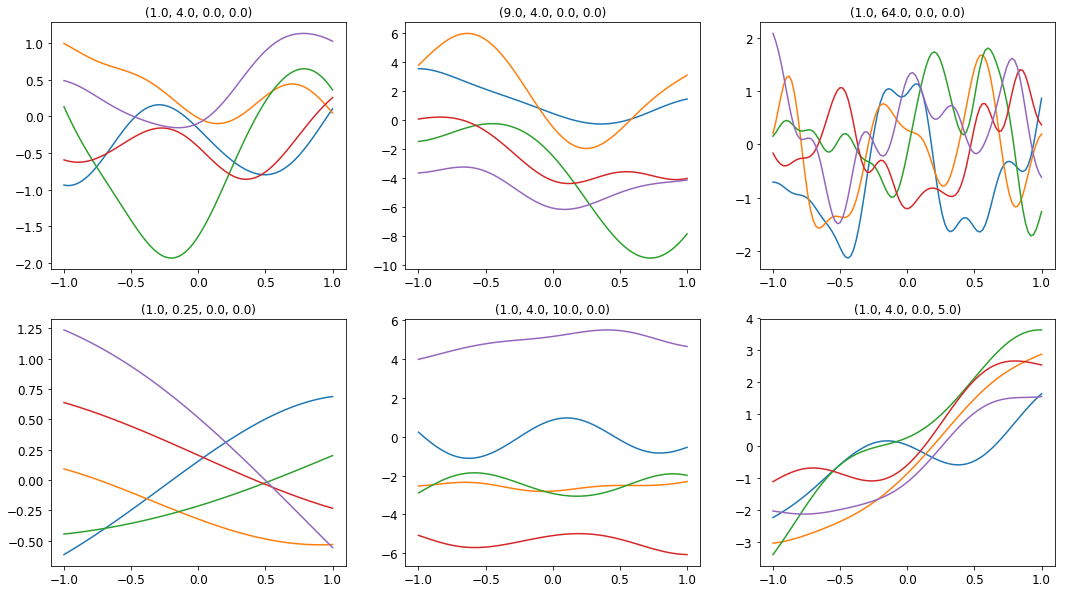

In [5]:
X = np.linspace(-1,1,101)
X = np.reshape(X, (len(X),-1))
Thts = np.array([[1.0, 4.0, 0.0, 0.0],
                 [9.0, 4.0, 0.0, 0.0],
                 [1.0, 64.0, 0.0,0.0],
                 [1.0,0.25, 0.0, 0.0],
                 [1.0, 4.0, 10.0, 0.0],
                 [1.0, 4.0, 0.0, 5.0]
                ])

num  = 5
cnt = 0
fig = plt.figure(figsize=(18,10))
while cnt < len(Thts):
    theta = Thts[cnt]
    kernel = MyKernel(theta)
    Kmat = kernel(X, X)
    yy = np.random.multivariate_normal(np.zeros(len(X)), Kmat, num)
    ax = fig.add_subplot(2,3,cnt+1)
    for y in yy:
        ax.plot(X, y)
    ax.set_title(f"({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]})")
    cnt += 1

It can be seen that $\theta_1$ determines the scale of change(smaller $\theta_1$ means more oscillation).

## 4.2 Data

We use the following toy data for our regression task.

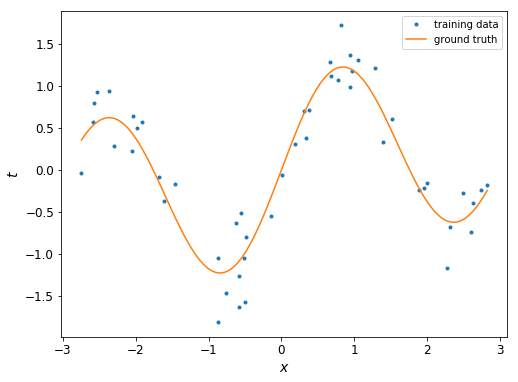

In [6]:
def truef(x):
    return np.sin(2*x)  + 0.2*np.sin(x) + 0.1*x

N = 50
X = np.random.uniform(-3, 3, N)
ep = 0.3*np.random.randn(N)
t = truef(X) + ep

Xcont = np.linspace(np.min(X),np.max(X),200) # for plotting

plt.figure(figsize=(8,6))
plt.plot(X, t,'.', label='training data')
plt.plot(Xcont, truef(Xcont), label='ground truth')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.legend()
plt.show()

X = np.reshape(X,(len(X),1))
Xtest = np.reshape(Xcont,(len(Xcont),1))

## 4.3 Regression (with fixed hyperparameters)

First, let us perform Gaussian process regression with given hyperparameters. 
We try several hyperparameters and see how they affect the result.

In [7]:
def plot_result(pred_mean, pred_std, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    ax.plot(X, t,'.',label='training data')
    ax.plot(Xcont, pred_mean, label='predictive mean')
    ax.plot(Xcont, truef(Xcont), ':', label='ground truth')
    ax.fill_between(Xcont, pred_mean + pred_std, pred_mean - pred_std, alpha=0.2)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$t$')
    ax.legend()

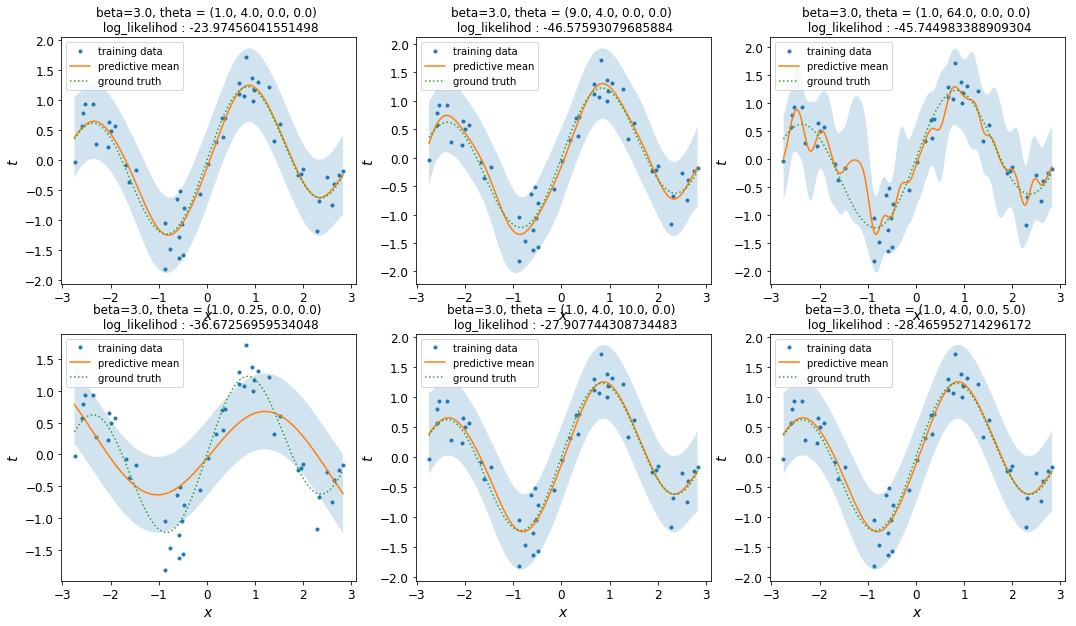

In [8]:
Thts = np.array([[1.0, 4.0, 0.0, 0.0],
                 [9.0, 4.0, 0.0, 0.0],
                 [1.0, 64.0, 0.0,0.0],
                 [1.0,0.25, 0.0, 0.0],
                 [1.0, 4.0, 10.0, 0.0],
                 [1.0, 4.0, 0.0, 5.0]
                ])


kernel = MyKernel(theta = np.array([0.0, 0.0, 0.0, 0.0]), bounds=[[0.0, None],[0.0, None],[0.0, None],[0.0, None]])
gpr = GPRegression(kernel=kernel, beta=3.0)

fig = plt.figure(figsize=(18,10))
cnt = 0
while cnt < len(Thts):
    theta = Thts[cnt]
    kernel.theta = theta
    gpr.fit(X, t)
    mean, std = gpr.predict(Xtest, return_std=True)
    ax = fig.add_subplot(2, 3, cnt+1)
    plot_result(mean, std, ax)
    ax.set_title(f"beta={gpr.beta}, theta = ({theta[0]}, {theta[1]}, {theta[2]}, {theta[3]}) \n log_likelihod : {-cost_and_grad(params=np.append([gpr.beta], [gpr.kernel.theta]), kernel=gpr.kernel, X=X, t=t, return_grad=False)}")
    cnt += 1
plt.show()

We can see that the quality of our prediction heavily depends on kernel parameters, especially on $\theta_1$, which governs the length scale.

## 4.4 Regression (optimization of hyperparameters)

Having seen that it is important to choose appropriate hyperparameters, here we let the algorithm it self to choose its favorite hyperparameters.

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
10.825187948939698
[0.76859425 1.43705475 0.         0.        ]
log_likelihod : 21.534692082749253


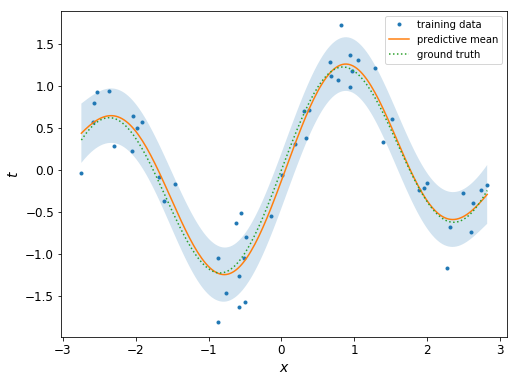

In [9]:
kernel = MyKernel(theta = np.array([2.0, 1.0, 0.01, 0.02]), bounds=[[0.0, None],[0.0, None],[0.0, None],[0.0, None]])
gpr = GPRegression(kernel=kernel, beta=1.0)
gpr.fit(X, t, optimize_hparams=True)
mean, std = gpr.predict(Xtest, return_std=True)
print(gpr.beta)
print(kernel.theta)
print(f"log_likelihod : {-cost_and_grad(params=np.append([gpr.beta], [gpr.kernel.theta]), kernel=gpr.kernel, X=X, t=t, return_grad=False)}")
plot_result(mean, std)

We can see that it gives much nicer result, with the value of log marginal likelihood much larger than those for the previoius section.

## Appendix scikit-learn

In this appendix, we see how to use scikit-learn library to perform the above analysis.

* http://scikit-learn.org/stable/modules/gaussian_process.html
* http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html

For simplicity, here we consider the Gaussian kernel only.

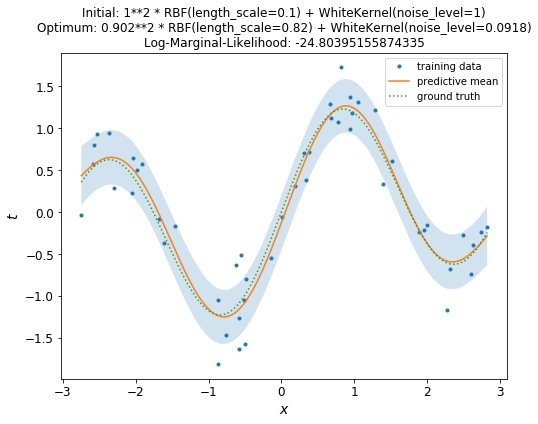

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1.0 * RBF(length_scale=0.1, length_scale_bounds=(1e-3, 1e2)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 3e+1))
gp = GaussianProcessRegressor(kernel=kernel,alpha=0.0)

# fitting 
gp.fit(X, t)

# prediction
y_mean, y_std = gp.predict(Xtest, return_std=True)

# plotting
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
plot_result(y_mean, y_std, ax)
ax.set_title(f"Initial: {kernel}\n\
Optimum: {gp.kernel_}\n\
Log-Marginal-Likelihood: {gp.log_marginal_likelihood(gp.kernel_.theta)}")
plt.show()

(Currently, I have not figured out where the discrepancy of the value of log marginal likelihood comes from.)